In [ ]:
import os
current_directory = os.getcwd()
dir_base = os.path.join(current_directory,'Dataset')

/home/ladans/DNN/Project/Extended model
/home/ladans/DNN/Project/Extended model/Dataset


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import logging
import pandas as pd
import glob
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from keras.models import Model
from keras.layers import Embedding, LSTM, Dense, Input, Concatenate, Dropout, Flatten, RepeatVector
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

2024-11-30 18:43:01.854128: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-30 18:43:01.865538: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732992181.877101  130078 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732992181.880762  130078 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-30 18:43:01.893998: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [ ]:
# Directory containing CSV files
data_dir = dir_base  # Define base directory

# Initialize an empty DataFrame
all_data = pd.DataFrame()

data_frames = []

# Iterate over each file in the directory
for file_path in glob.glob(os.path.join(data_dir, "*.csv")):
    stock_symbol = os.path.basename(file_path).split('.')[0]
    df = pd.read_csv(file_path)
    df['Stock_Symbol'] = stock_symbol
    df = df[['Date', 'Open', 'Close', 'Stock_Symbol']]
    data_frames.append(df)

all_data = pd.concat(data_frames, ignore_index=True)

# Sort data by date and stock symbol
all_data = all_data.sort_values(['Stock_Symbol', 'Date']).reset_index(drop=True)

# Encode stock symbols
encoder = LabelEncoder()
all_data['Stock_Index'] = encoder.fit_transform(all_data['Stock_Symbol'])

# Normalize prices using MinMaxScaler across all stocks
scaler = MinMaxScaler(feature_range=(0, 1))
all_data['Normalized_Close'] = all_data.groupby('Stock_Symbol')['Close'].transform(
    lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten()
)


In [5]:
all_data

,Date,Open,Close,Stock_Symbol,Stock_Index,Normalized_Close
0,2012-09-04,95.108574,96.424286,AAPL,0,0.375340
1,2012-09-05,96.510002,95.747147,AAPL,0,0.369085
2,2012-09-06,96.167145,96.610001,AAPL,0,0.377055
3,2012-09-07,96.864288,97.205711,AAPL,0,0.382558
4,2012-09-10,97.207146,94.677139,AAPL,0,0.359201
...,...,...,...,...,...,...
15792,2017-08-28,73.059998,72.830002,MSFT,12,0.959917
15793,2017-08-29,72.250000,73.050003,MSFT,12,0.964463
15794,2017-08-30,73.010002,74.010002,MSFT,12,0.984298
15795,2017-08-31,74.029999,74.769997,MSFT,12,1.000000


In [ ]:
# Parameters
sequence_length = 34  # Adjusted based on optimization

# Initialize lists for inputs and outputs
X, y, stock_indices = [], [], []

for stock in all_data['Stock_Symbol'].unique():
    stock_data = all_data[all_data['Stock_Symbol'] == stock]
    normalized_prices = stock_data['Normalized_Close'].values

    # Create sequences of length `sequence_length`
    for i in range(len(normalized_prices) - sequence_length):
        X.append(normalized_prices[i: i + sequence_length])
        y.append(normalized_prices[i + sequence_length])
        stock_indices.append(stock_data['Stock_Index'].iloc[0])

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)
stock_indices = np.array(stock_indices)
logging.info("Finished converting to numpy array")

done


In [7]:
X.shape

(15355, 34)

In [8]:
X

array([[0.37533978, 0.36908503, 0.37705523, ..., 0.33527749, 0.31948219,
        0.28939591],
       [0.36908503, 0.37705523, 0.38255782, ..., 0.31948219, 0.28939591,
        0.32131639],
       [0.37705523, 0.38255782, 0.35920134, ..., 0.28939591, 0.32131639,
        0.29404078],
       ...,
       [0.93801652, 0.95888434, 0.97066118, ..., 0.9597108 , 0.95991746,
        0.96446293],
       [0.95888434, 0.97066118, 0.96962822, ..., 0.95991746, 0.96446293,
        0.98429762],
       [0.97066118, 0.96962822, 0.98119843, ..., 0.96446293, 0.98429762,
        1.        ]])

In [9]:
y

array([0.32131639, 0.29404078, 0.29861968, ..., 0.98429762, 1.        ,
       0.98285134])

In [10]:
stock_indices

array([ 0,  0,  0, ..., 12, 12, 12])

In [25]:
# Train-test split
train_ratio = 0.7
validation_ratio = 0.25
test_ratio = 0.05

# Calculate split sizes
train_size = int(len(X) * train_ratio)
validation_size = int(len(X) * validation_ratio)

# Perform the splits
X_train = X[:train_size]
y_train = y[:train_size]
stock_indices_train = stock_indices[:train_size]

X_val = X[train_size:train_size + validation_size]
y_val = y[train_size:train_size + validation_size]
stock_indices_val = stock_indices[train_size:train_size + validation_size]

X_test = X[train_size + validation_size:]
y_test = y[train_size + validation_size:]
stock_indices_test = stock_indices[train_size + validation_size:]

# Reshape inputs for LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Print sizes for verification
print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")

Training samples: 10748
Validation samples: 3838
Test samples: 769


In [26]:
#Model:
# Number of unique stocks and embedding dimensions
num_stocks = len(all_data['Stock_Symbol'].unique())
embedding_size =23 # Increased embedding size based on Optuna

# Define inputs
price_input = Input(shape=(sequence_length,1), name="price_input")
stock_input = Input(shape=(1,), name="stock_input")


# Embedding layer for stock index
stock_embedding = Embedding(input_dim=num_stocks, output_dim=embedding_size)(stock_input)
stock_embedding = Flatten()(stock_embedding)  # Flatten to 2D (batch_size, embedding_size)
stock_embedding = RepeatVector(sequence_length)(stock_embedding)  # Replicate to match LSTM input shape

# Concatenate price input with stock embedding
merged_input = Concatenate(axis=2)([price_input, stock_embedding])


# LSTM layer
# LSTM layers with dropout
lstm_out = LSTM(units=256, return_sequences=True)(merged_input)
lstm_out = Dropout(0.1)(lstm_out)
lstm_out = LSTM(units=128)(lstm_out)

# Output layer
output = Dense(units=1)(lstm_out)


# Define and compile the model
model = Model(inputs=[price_input, stock_input], outputs=output)
model.compile(optimizer='adam', loss='mean_squared_error')

from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',     # Metric to monitor (validation loss in this case)
    patience=10,            # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restore weights from the epoch with the best validation loss
)

# Train the model with EarlyStopping callback
history = model.fit(
    [X_train, stock_indices_train], y_train,
    validation_data=([X_val, stock_indices_val], y_val),
    epochs=70,               # Maximum number of epochs (model may stop earlier due to early stopping)
    batch_size=64,           # Batch size optimized using Optuna
    verbose=1,
    callbacks=[early_stopping]  # Include the EarlyStopping callback here
)


Epoch 1/70
168/168 ━━━━━━━━━━━━━━━━━━━━ 20s 109ms/step - loss: 0.0219 - val_loss: 0.0018
Epoch 2/70
168/168 ━━━━━━━━━━━━━━━━━━━━ 18s 109ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 3/70
168/168 ━━━━━━━━━━━━━━━━━━━━ 18s 109ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 4/70
168/168 ━━━━━━━━━━━━━━━━━━━━ 18s 107ms/step - loss: 9.1746e-04 - val_loss: 0.0012
Epoch 5/70
168/168 ━━━━━━━━━━━━━━━━━━━━ 18s 108ms/step - loss: 7.9657e-04 - val_loss: 8.1101e-04
Epoch 6/70
168/168 ━━━━━━━━━━━━━━━━━━━━ 18s 108ms/step - loss: 7.0446e-04 - val_loss: 6.8960e-04
Epoch 7/70
168/168 ━━━━━━━━━━━━━━━━━━━━ 18s 108ms/step - loss: 6.3252e-04 - val_loss: 6.9474e-04
Epoch 8/70
168/168 ━━━━━━━━━━━━━━━━━━━━ 18s 109ms/step - loss: 5.7234e-04 - val_loss: 5.6964e-04
Epoch 9/70
168/168 ━━━━━━━━━━━━━━━━━━━━ 18s 108ms/step - loss: 5.5133e-04 - val_loss: 5.6338e-04
Epoch 10/70
168/168 ━━━━━━━━━━━━━━━━━━━━ 18s 108ms/step - loss: 5.1619e-04 - val_loss: 9.5656e-04
Epoch 11/70
168/168 ━━━━━━━━━━━━━━━━━━━━ 18s 109ms/step -

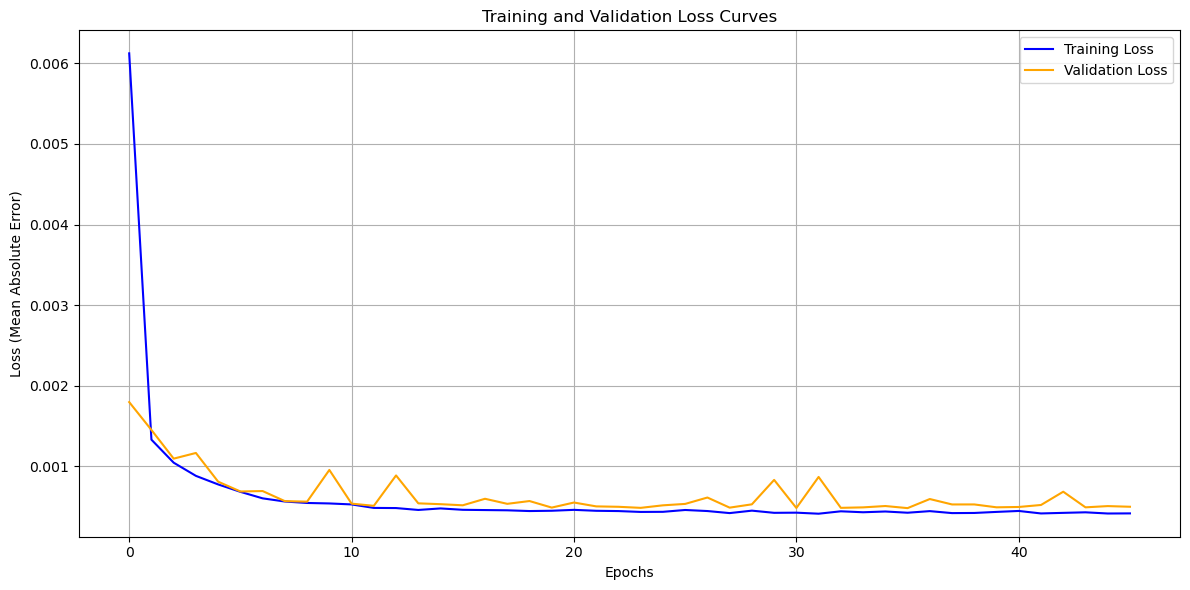

In [ ]:
# Extract training and validation losses
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss (Mean Absolute Error)')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('training_loss_optimized')
plt.show()


In [ ]:
# Assuming `model` is your trained model, `X_test` is your test data input
predicted_prices = model.predict([X_test, stock_indices_test])

# Denormalize predictions and actual values
def denormalize(values, stock_symbol):
    scaler = MinMaxScaler(feature_range=(0, 1))
    stock_prices = all_data[all_data['Stock_Symbol'] == stock_symbol]['Close'].values
    scaler.fit(stock_prices.reshape(-1, 1))
    return scaler.inverse_transform(values.reshape(-1, 1)).flatten()

y_test_denormalized = np.concatenate([
    denormalize(y_test[stock_indices_test == stock_id], encoder.inverse_transform([stock_id])[0])
    for stock_id in np.unique(stock_indices_test)
])

predicted_prices_denormalized = np.concatenate([
    denormalize(predicted_prices[stock_indices_test == stock_id], encoder.inverse_transform([stock_id])[0])
    for stock_id in np.unique(stock_indices_test)
])

# Calculate metrics
mae = mean_absolute_error(y_test_denormalized, predicted_prices_denormalized)
mse = mean_squared_error(y_test_denormalized, predicted_prices_denormalized)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test_denormalized - predicted_prices_denormalized) / y_test_denormalized)) * 100

print("MAE (Original Scale):", mae)
print("MSE (Original Scale):", mse)
print("RMSE (Original Scale):", rmse)
print("MAPE:", mape, "%")

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
MAE (Original Scale): 0.5258858115466136
MSE (Original Scale): 0.5492996611505139
RMSE (Original Scale): 0.7411475299496814
MAPE: 1.010062320770377 %


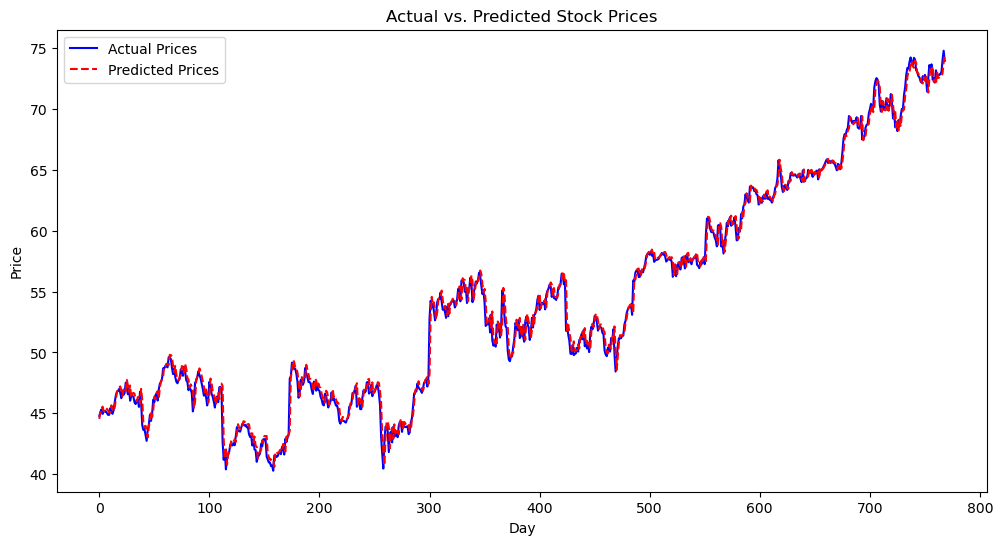

In [ ]:
# Plot reversed actual vs. predicted prices
plt.figure(figsize=(12, 6))
plt.plot(y_test_denormalized, label="Actual Prices", color="blue")
plt.plot(predicted_prices_denormalized, label="Predicted Prices", color="red",linestyle='--')
plt.xlabel("Day")
plt.ylabel("Price")
plt.title("Actual vs. Predicted Stock Prices")
plt.legend()
plt.savefig('actual_prediction_optimized')
plt.show()

# Evaluate per-stock metrics
for stock_id in np.unique(stock_indices_test):
    stock_mask = stock_indices_test == stock_id
    stock_symbol = encoder.inverse_transform([stock_id])[0]
    stock_mae_reversed = mean_absolute_error(
        y_test_denormalized[stock_mask], predicted_prices_denormalized[stock_mask]
    )

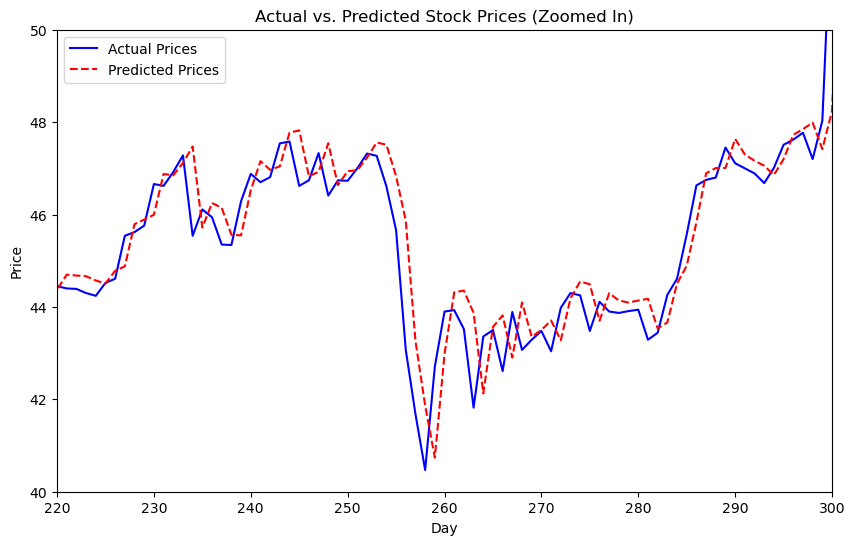

In [36]:
plt.figure(figsize=(10, 6))
plt.plot(y_test_denormalized, label="Actual Prices", color="blue")
plt.plot(predicted_prices_denormalized, label="Predicted Prices", color="red", linestyle='--')

# Set axis limits to zoom in on a specific section
plt.xlim(220, 300)  # Zoom into x-axis (e.g., focus on indices 100 to 200)
plt.ylim(40, 50)    # Zoom into y-axis (e.g., focus on prices between 40 and 60)

plt.title("Actual vs. Predicted Stock Prices (Zoomed In)")
plt.xlabel("Day")
plt.ylabel("Price")
plt.legend()
plt.savefig('zoomed')
plt.show()


In [ ]:
# Predict the next price for a new sequence
array_34_values = X_test[-1]  

# Reshape new_sequence to match the model's expected input shape
new_sequence = array_34_values.reshape((1, sequence_length, 1))

# Find the encoded index for the desired stock (e.g., MSFT)
stock_index = encoder.transform(['MSFT'])

# Predict the normalized price
predicted_normalized_price = model.predict([new_sequence, stock_index])

# Reverse normalization to get the predicted price in the original scale
predicted_price_original_scale = scaler.inverse_transform(predicted_normalized_price)[0][0]

print("Predicted next price for MSFT (original scale):", predicted_price_original_scale)

Predicted next price for MSFT (original scale): 74.51344